In [12]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from xgboost import XGBClassifier, XGBRegressor
from shap import TreeExplainer, initjs, force_plot
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [13]:
train = pd.read_csv( 'train.csv' , index_col= 'id' )

test = pd.read_csv( 'test.csv' , index_col = 'id' )

In [14]:
train.rename( columns = { 'number_of_total_atoms' : 'tot_atom' , 
                          'percent_atom_al' : 'al_atom_p' ,
                          'percent_atom_ga' : 'ga_atom_p' , 
                          'percent_atom_in' : 'in_atom_p' , 
                          'lattice_vector_1_ang' : 'ang_1' ,
                          'lattice_vector_2_ang' : 'ang_2' , 
                          'lattice_vector_3_ang' : 'and_3' ,
                          'lattice_angle_alpha_degree' : 'angle_a' , 
                          'lattice_angle_beta_degree' : 'angle_b' ,
                          'lattice_angle_gamma_degree' : 'angle_g' ,
                          'formation_energy_ev_natom' : 'f_energy' ,
                          'bandgap_energy_ev' : 'bg_energy' } , inplace = True )

test.rename( columns = { 'number_of_total_atoms' : 'tot_atom' , 
                         'percent_atom_al' : 'al_atom_p' ,
                         'percent_atom_ga' : 'ga_atom_p' , 
                         'percent_atom_in' : 'in_atom_p' , 
                         'lattice_vector_1_ang' : 'ang_1' ,
                         'lattice_vector_2_ang' : 'ang_2' , 
                         'lattice_vector_3_ang' : 'and_3' ,
                         'lattice_angle_alpha_degree' : 'angle_a' , 
                         'lattice_angle_beta_degree' : 'angle_b' ,
                         'lattice_angle_gamma_degree' : 'angle_g' } , inplace = True )

def wrangle(df):

    atoms = [ 'al' , 'ga' , 'in' ]
    
    for elem in atoms:
        df[ f'{ elem }_atoms' ] = df.tot_atom * df[ f'{ elem }_atom_p' ]
    
    df[ 'al_ga_ratio' ] = df.al_atoms / df.ga_atoms
    df[ 'al_in_ratio' ] = df.al_atoms / df.in_atoms
    df[ 'in_ga_ratio' ] = df.in_atoms / df.ga_atoms

    ratios = [ 'al_ga_ratio' , 'al_in_ratio' , 'in_ga_ratio' ]
    nulls = [ np.nan , np.inf ]
    
    for col in ratios:
        df[ col ] = df[ col ].replace( np.inf , np.nan )
        df[ col ] = df[ col ].replace( np.nan , df[ col ].median() )
    
    return df

train = wrangle( train )

test = wrangle( test )

In [23]:
target1 = 'bg_energy'
target2 = 'f_energy'

X = train.drop( columns = [ target1 , target2 ] )
X_test = test

y1 = train[ target1 ]
y2 = train[ target2 ]

In [24]:
X1_train, X1_val, y1_train, y1_val = train_test_split( 
    X , y1 , train_size = 0.9 , random_state = 19 )

X2_train, X2_val, y2_train, y2_val = train_test_split( 
    X , y2 , train_size = 0.9 , random_state = 19 )

y1_pred = [y1_train.mean()] * len(y1_train)
y2_pred = [y2_train.mean()] * len(y2_train)

print('Band Gap Energy')
print('Mean (eV): ', y1_train.mean())
print('Baseline MAE: ' , mean_absolute_error( y1_train , y1_pred ) )
print()
print('Formation Energy')
print('Mean (eV): ', y2_train.mean())
print('Baseline MAE: ' , mean_absolute_error( y2_train , y2_pred ) )

Band Gap Energy
Mean (eV):  2.0804772685185187
Baseline MAE:  0.8267515736025377

Formation Energy
Mean (eV):  0.18696375
Baseline MAE:  0.08535369444444445


In [25]:
ss = StandardScaler()

# rscv =  RandomizedSearchCV()
lr = LinearRegression()
logr = LogisticRegression( random_state = 19 )
xgbr = XGBRegressor( n_estimators = 100 , random_state = 42 )
rfr = RandomForestRegressor( n_estimators = 100 , random_state = 42 )

model_lr = make_pipeline( ss , lr )
model_logr = make_pipeline( ss , logr ) 
model_xgbr = make_pipeline( ss , xgbr )
model_rfr = make_pipeline( ss , rfr )

model_lr1 = model_lr.fit( X1_train , y1_train );
model_xgbr1 = model_xgbr.fit( X1_train , y1_train );
model_rfr1 = model_rfr.fit( X1_train , y1_train );

model_lr2 = model_lr.fit( X2_train , y2_train );
model_xgbr2 = model_xgbr.fit( X2_train , y2_train );
model_rfr2 = model_rfr.fit( X2_train , y2_train );

{'standardscaler': StandardScaler(), 'linearregression': LinearRegression()}

In [49]:
models1 = [ model_lr1 , model_rfr1 , model_xgbr1 ]

models2 = [ model_lr2 , model_rfr2 , model_xgbr2 ]

print('Band Gap Energy')
for model in models1:
    print('LR training MAE : ' , 
          mean_absolute_error( y1_train , model.predict( X1_train ) ) )
    print('LR validatio
          n MAE: ' , 
          mean_absolute_error( y1_val , model.predict( X1_val ) ) )
    
# print()
    
# for model in models2:
#     print('Training MAE: ' , 
#           mean_absolute_error( y2_train , model.predict( X2_train ) ) )
#     print('Validation MAE: ' , 
#           mean_absolute_error( y2_val , model.predict( X2_val ) ) )

Band Gap Energy


AttributeError: 'Pipeline' object has no attribute '__name__'

In [70]:
dic = { 'target' : [ 'Band Gap' , 'Formation' ] ,
         'modna' : [ 'LR' , 'RFR' , 'XGBR' ] ,
         'bgmod' : [ model_lr1 , model_rfr1 , model_xgbr1 ] ,
         'fmod' : [ model_lr2 , model_rfr2 , model_xgbr2 ] }

for n in dic['bgmod']:
    print( dic[target][0] , ' training MAE: ' , mean_absolute_error( 
                                                y1_train , model.predict( X1_train ) ) )
    print( dic[target][0] , ' validation MAE: ' , mean_absolute_error( 
                                                  y1_val , model.predict( X1_val ) ) )

KeyError: 'bg_energy'

In [8]:
X_train.columns

Index(['spacegroup', 'tot_atom', 'al_atom_p', 'ga_atom_p', 'in_atom_p',
       'ang_1', 'ang_2', 'and_3', 'angle_a', 'angle_b', 'angle_g', 'al_atoms',
       'ga_atoms', 'in_atoms', 'al_ga_ratio', 'al_in_ratio', 'in_ga_ratio'],
      dtype='object')

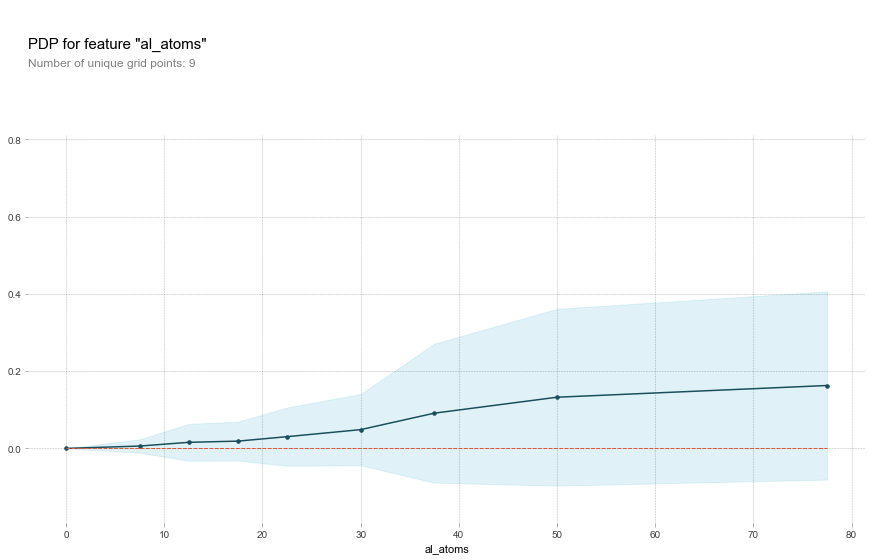

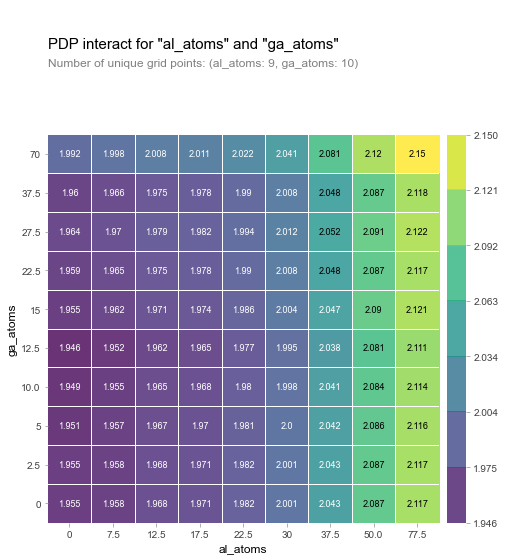

In [9]:
feature = 'al_atoms'
features = ['al_atoms', 'ga_atoms']

isolate = pdp_isolate( model = model_xgbr ,
                       dataset = X_val ,
                       model_features = X_val.columns ,
                       feature = feature )

pdp_plot( isolate, feature_name = feature );

interact = pdp_interact( model = model_xgbr ,
                         dataset = X_val ,
                         model_features = X_val.columns ,
                         features = features )

pdp_interact_plot( interact , plot_type = 'grid' , feature_names = features );

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 1012 to 1630
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   spacegroup   2160 non-null   int64  
 1   tot_atom     2160 non-null   float64
 2   al_atom_p    2160 non-null   float64
 3   ga_atom_p    2160 non-null   float64
 4   in_atom_p    2160 non-null   float64
 5   ang_1        2160 non-null   float64
 6   ang_2        2160 non-null   float64
 7   and_3        2160 non-null   float64
 8   angle_a      2160 non-null   float64
 9   angle_b      2160 non-null   float64
 10  angle_g      2160 non-null   float64
 11  al_atoms     2160 non-null   float64
 12  ga_atoms     2160 non-null   float64
 13  in_atoms     2160 non-null   float64
 14  al_ga_ratio  2160 non-null   float64
 15  al_in_ratio  2160 non-null   float64
 16  in_ga_ratio  2160 non-null   float64
dtypes: float64(16), int64(1)
memory usage: 303.8 KB
